## Surface-Aware Match Outcome Model (Elo + Logistic Regression)

In this section, we build a **machine learning model** on top of the Elo ratings from our ATP dataset to estimate the probability that a given player (player1) wins a match.

**Goal**

- Use **Elo rating differences**, **age differences**, and **surface information** (Hard / Clay / Grass) to predict match outcomes.
- Understand how **win probability** changes with **Elo difference** across different surfaces.

**Key ideas**

- We start from the precomputed Elo dataset: `Data/ML_final.csv`.
- We construct a **symmetric dataset** where each match appears twice:
  - Once with the winner as `player1` (label = 1).
  - Once with the loser as `player1` (label = 0).
- We then train a **logistic regression** model with proper preprocessing (imputation, scaling, one-hot encoding) and evaluate it on a held-out test set.
- Finally, we analyze how predicted win probability varies with Elo difference on Hard / Clay / Grass.



In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.impute import SimpleImputer


# 1. Load ML dataset ---------------------------------------------------------

BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "Data" / "ML_final.csv"

print("Working dir :", BASE_DIR)
print("Reading file:", DATA_PATH)

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. "
        f"Run create_ml_dataset.py or check the filename."
    )

df = pd.read_csv(DATA_PATH)

# Keep only main ATP surfaces we care about
valid_surfaces = ["Hard", "Clay", "Grass"]
df = df[df["surface"].isin(valid_surfaces)].copy()

# Make sure tourney_date is a datetime and we have a year column (for info/logs)
df["tourney_date"] = pd.to_datetime(df["tourney_date"], errors="coerce")
df["year"] = df["tourney_date"].dt.year

print("Rows after surface filter:", len(df))



KeyboardInterrupt: 

## Loading Elo-Based Dataset and Filtering Surfaces

We begin by loading the Elo-enriched match dataset:

- The file `Data/ML_final.csv` is generated by earlier preprocessing scripts.
- We restrict to the three main ATP surfaces:
  - **Hard**
  - **Clay**
  - **Grass**

We also:

- Parse `tourney_date` into a proper datetime.
- Derive a `year` column (mostly for logging and potential temporal analysis).
- Print the number of rows after filtering to confirm data size.


In [16]:

# 2. Build a symmetric player1/player2 dataset -------------------------------

def build_symmetric_dataset(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    For each match, create two rows:
      - row A: player1 = winner, label = 1
      - row B: player1 = loser,  label = 0
    This makes the model treat "player1" and "player2" symmetrically.
    """
    rows = []

    has_age = "winner_age" in df_in.columns and "loser_age" in df_in.columns
    has_level = "tourney_level" in df_in.columns
    has_round = "round" in df_in.columns

    for _, row in df_in.iterrows():
        # Skip rows without Elo information
        if pd.isna(row.get("winner_elo")) or pd.isna(row.get("loser_elo")):
            continue

        surface = row["surface"]
        year = row.get("year", np.nan)

        tourney_level = row["tourney_level"] if has_level else "Unknown"
        round_code = row["round"] if has_round else "Unknown"

        winner_elo = float(row["winner_elo"])
        loser_elo = float(row["loser_elo"])

        if has_age:
            winner_age = float(row["winner_age"])
            loser_age = float(row["loser_age"])
        else:
            winner_age = np.nan
            loser_age = np.nan

        # Row 1: player1 is winner
        rows.append({
            "surface": surface,
            "year": year,
            "tourney_level": tourney_level,
            "round": round_code,
            "elo_p1": winner_elo,
            "elo_p2": loser_elo,
            "age_p1": winner_age,
            "age_p2": loser_age,
            "p1_wins": 1,
        })

        # Row 2: player1 is loser
        rows.append({
            "surface": surface,
            "year": year,
            "tourney_level": tourney_level,
            "round": round_code,
            "elo_p1": loser_elo,
            "elo_p2": winner_elo,
            "age_p1": loser_age,
            "age_p2": winner_age,
            "p1_wins": 0,
        })

    return pd.DataFrame(rows)


sym_df = build_symmetric_dataset(df)
print("Symmetric dataset rows:", len(sym_df))


KeyboardInterrupt: 

## Symmetric Player1/Player2 Dataset

To avoid biasing the model toward a fixed "winner" or "loser" role, we convert each match into **two training examples**:

1. **Row A**:  
   - `player1 = winner`, `player2 = loser`  
   - label `p1_wins = 1`

2. **Row B**:  
   - `player1 = loser`, `player2 = winner`  
   - label `p1_wins = 0`

This has several advantages:

- The model learns a concept of **relative strength** (Elo difference, age difference) rather than memorizing specific columns like `winner_*` or `loser_*`.
- We can query the model for **any arbitrary pair of players** by assigning one as player1 and the other as player2.

For each row we keep:

- `surface`, `year`, `tourney_level`, `round`
- `elo_p1`, `elo_p2` (Elo ratings for player1 and player2)
- `age_p1`, `age_p2` if age is available
- The binary target label: `p1_wins`


In [ ]:
# 3. Feature engineering -----------------------------------------------------

# Basic differences
sym_df["elo_diff"] = sym_df["elo_p1"] - sym_df["elo_p2"]
sym_df["age_diff"] = sym_df["age_p1"] - sym_df["age_p2"]

# Surface-specific interaction features:
#   elo_diff_hard  = elo_diff if surface == "Hard"  else 0
#   elo_diff_clay  = elo_diff if surface == "Clay"  else 0
#   elo_diff_grass = elo_diff if surface == "Grass" else 0
sym_df["elo_diff_hard"] = 0.0
sym_df["elo_diff_clay"] = 0.0
sym_df["elo_diff_grass"] = 0.0

sym_df.loc[sym_df["surface"] == "Hard", "elo_diff_hard"] = sym_df["elo_diff"]
sym_df.loc[sym_df["surface"] == "Clay", "elo_diff_clay"] = sym_df["elo_diff"]
sym_df.loc[sym_df["surface"] == "Grass", "elo_diff_grass"] = sym_df["elo_diff"]

# Ensure tourney_level column exists & handle NaNs
if "tourney_level" not in sym_df.columns:
    sym_df["tourney_level"] = "Unknown"
else:
    sym_df["tourney_level"] = sym_df["tourney_level"].fillna("Unknown")

# Drop rows with missing label, just in case
sym_df = sym_df.dropna(subset=["p1_wins"]).copy()

print(sym_df[["surface", "elo_diff", "elo_diff_hard",
              "elo_diff_clay", "elo_diff_grass"]].head())




  surface    elo_diff  elo_diff_hard  elo_diff_clay  elo_diff_grass
0    Hard  343.501197     343.501197            0.0             0.0
1    Hard -343.501197    -343.501197            0.0             0.0
2    Hard  480.929366     480.929366            0.0             0.0
3    Hard -480.929366    -480.929366            0.0             0.0
4    Hard  447.347334     447.347334            0.0             0.0
Train rows: 92148  Test rows: 23038

=== Evaluation on test set ===
Accuracy:    0.666
ROC AUC:     0.735
Brier score: 0.208

Example probabilities for elo_diff=75, age_diff=-2:
  surface  p1_win_probability
0    Hard            0.607790
1    Clay            0.600872
2   Grass            0.607705


## Feature Engineering: Elo and Surface Interactions

Next, we construct the features that will be used by the model.

**Basic features**

- `elo_diff = elo_p1 - elo_p2`  
  → Positive if player1 is stronger by Elo, negative if weaker.
- `age_diff = age_p1 - age_p2`  
  → Positive if player1 is older, negative if younger.

**Surface-specific interaction features**

To let the model capture that Elo **behaves differently on different surfaces**, we create:

- `elo_diff_hard`
- `elo_diff_clay`
- `elo_diff_grass`

For each row:

- If the match is on **Hard**, we set `elo_diff_hard = elo_diff` and the others to 0.
- If the match is on **Clay**, we set `elo_diff_clay = elo_diff` and the others to 0.
- If the match is on **Grass**, we set `elo_diff_grass = elo_diff` and the others to 0.

This effectively gives the model **separate Elo coefficients per surface** inside a single logistic regression.

We also:

- Ensure `tourney_level` exists and fill missing values with `"Unknown"`.
- Drop any rows where the label `p1_wins` is missing (for safety).


In [ ]:

# 4. Train / test split (standard 80/20) ------------------------------------

feature_cols_numeric = [
    "elo_diff_hard",
    "elo_diff_clay",
    "elo_diff_grass",
    "age_diff",
]
feature_cols_categ = ["tourney_level"]

X = sym_df[feature_cols_numeric + feature_cols_categ]
y = sym_df["p1_wins"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train rows:", len(X_train), " Test rows:", len(X_test))



## Train/Test Split and Preprocessing Pipeline

We now prepare the data for model training.

**Feature sets**

- **Numeric features**
  - `elo_diff_hard`
  - `elo_diff_clay`
  - `elo_diff_grass`
  - `age_diff`
- **Categorical feature**
  - `tourney_level` (e.g., Grand Slam, Masters, ATP 500, etc.)

**Train/test split**

- We use an 80/20 **random train/test split** with stratification on `p1_wins`:
  - 80% of the data for training.
  - 20% for evaluation on unseen matches.

**Preprocessing with sklearn Pipelines**

- For **numeric features**:
  - Impute missing values with the **median**.
  - Standardize using **StandardScaler**.
- For **categorical features**:
  - Impute missing values with the most frequent category.
  - Apply **OneHotEncoder** with `handle_unknown="ignore"`.

These transformations are combined in a `ColumnTransformer`, which is then chained with a `LogisticRegression` model into a single `Pipeline`. Training the pipeline automatically applies preprocessing + model fitting in the correct order.


In [ ]:

# 5. Build pipeline: preprocessing + logistic regression ---------------------

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_numeric),
        ("cat", categorical_transformer, feature_cols_categ),
    ]
)

log_reg = LogisticRegression(max_iter=1000)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg),
])

clf.fit(X_train, y_train)



## Training Logistic Regression and Evaluating Performance

We fit the logistic regression model on the training set and evaluate it on the held-out test set.

**Metrics reported**

- **Accuracy**  
  Fraction of matches where the predicted winner (player1 or player2) is correct.

- **ROC AUC (Area Under ROC Curve)**  
  Measures how well the model ranks winning vs losing cases:
  - Interpreted as:  
    "Given a random match player1 wins and a random match player1 loses, how often does the model assign a higher win probability to the winning case?"

- **Brier Score**  
  Measures the quality of the **predicted probabilities** (lower is better):
  - A Brier score close to 0 indicates well-calibrated probabilities.
  - Values around ~0.2 are decent for this kind of sports outcome modeling.

These metrics together give a good view of both **discriminative power** (ROC AUC) and **probability calibration** (Brier score).


In [ ]:

# 6. Evaluation --------------------------------------------------------------

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)

print("\n=== Evaluation on test set ===")
print(f"Accuracy:    {acc:.3f}")
print(f"ROC AUC:     {auc:.3f}")
print(f"Brier score: {brier:.3f}")



## Win Probability Across Surfaces for a Given Matchup

To understand how **surface** influences the outcome, we define a helper function:

- `predict_across_surfaces(model, elo_diff, age_diff, tourney_level, surfaces)`

For a fixed Elo and age difference between player1 and player2, this function:

1. Constructs feature rows for each surface (Hard, Clay, Grass).
2. Recomputes the surface-specific interaction features:
   - `elo_diff_hard`, `elo_diff_clay`, `elo_diff_grass`.
3. Uses the trained model to predict `p1_win_probability` for each surface.

This lets us answer questions like:

> “If player1 is 75 Elo points stronger and 2 years younger than player2,  
> what is the chance they win on Hard vs Clay vs Grass in a Grand Slam?”


In [ ]:

# 7. Helper: predict win probability across surfaces ------------------------

def predict_across_surfaces(
    model,
    elo_diff: float,
    age_diff: float = 0.0,
    tourney_level: str = "G",
    surfaces=("Hard", "Clay", "Grass"),
) -> pd.DataFrame:
    """
    For a given Elo difference and age difference, return the predicted
    probability that player1 wins on each surface.
    """
    rows = []

    for surf in surfaces:
        row = {
            "surface": surf,
            "elo_diff": elo_diff,
            "age_diff": age_diff,
            "tourney_level": tourney_level,
        }

        # Build interaction features the same way as training
        if surf == "Hard":
            row["elo_diff_hard"] = elo_diff
            row["elo_diff_clay"] = 0.0
            row["elo_diff_grass"] = 0.0
        elif surf == "Clay":
            row["elo_diff_hard"] = 0.0
            row["elo_diff_clay"] = elo_diff
            row["elo_diff_grass"] = 0.0
        elif surf == "Grass":
            row["elo_diff_hard"] = 0.0
            row["elo_diff_clay"] = 0.0
            row["elo_diff_grass"] = elo_diff
        else:
            row["elo_diff_hard"] = 0.0
            row["elo_diff_clay"] = 0.0
            row["elo_diff_grass"] = 0.0

        rows.append(row)

    X_new = pd.DataFrame(rows)[feature_cols_numeric + feature_cols_categ]
    probs = model.predict_proba(X_new)[:, 1]

    surface_probs = pd.DataFrame({
        "surface": list(surfaces),
        "p1_win_probability": probs,
    })

    return surface_probs


# Example usage --------------------------------------------------------------

example = predict_across_surfaces(
    clf,
    elo_diff=75.0,     # player1 has 75 Elo points more than player2
    age_diff=-2.0,     # player1 is 2 years younger
    tourney_level="G"  # Grand Slam
)

print("\nExample probabilities for elo_diff=75, age_diff=-2:")
print(example)


## Win Probability Curves as a Function of Elo Difference

To visualize the relationship between **Elo difference** and **win probability**, we:

1. Sweep `elo_diff` over a range (e.g., from -200 to +200 in steps of 25).
2. For each value of `elo_diff`, call `predict_across_surfaces` to obtain the predicted win probability for player1 on:
   - Hard
   - Clay
   - Grass
3. Store the results in a DataFrame (`curve_df`) with columns:
   - `elo_diff`
   - `surface`
   - `p1_win_probability`

By plotting `p1_win_probability` vs `elo_diff` for each surface, we obtain smooth curves that:

- Show how the model’s predicted win probability transitions from underdog (negative Elo diff) to favorite (positive Elo diff).
- Reveal whether certain surfaces slightly favor stronger or weaker players under the same Elo difference.

This plot is a compact summary of the model’s behavior and is ideal for use in presentations or reports.


In [22]:
import numpy as np

elo_diffs = np.arange(-200, 201, 25)  # from -200 to +200 in steps of 25
rows = []

for d in elo_diffs:
    probs = predict_across_surfaces(
        clf,
        elo_diff=d,
        age_diff=0.0,
        tourney_level="G"
    )
    probs["elo_diff"] = d
    rows.append(probs)

curve_df = pd.concat(rows, ignore_index=True)
print(curve_df.head())


  surface  p1_win_probability  elo_diff
0    Hard            0.259313      -200
1    Clay            0.274406      -200
2   Grass            0.259496      -200
3    Hard            0.285137      -175
4    Clay            0.299096      -175


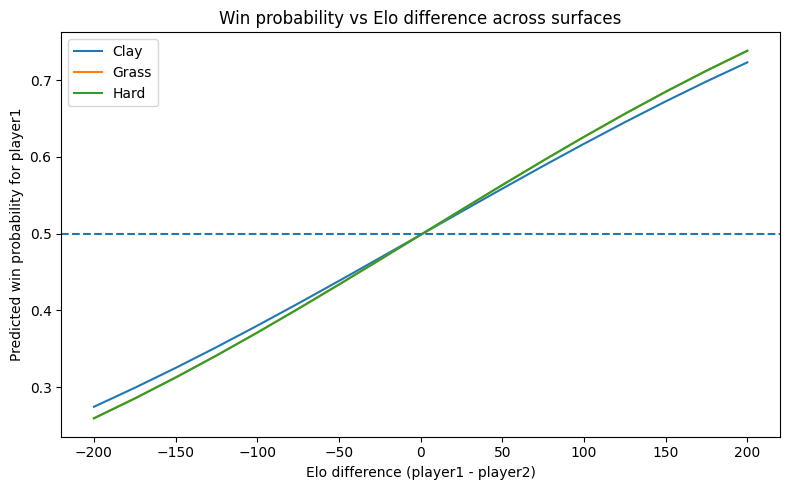

In [24]:
import matplotlib.pyplot as plt

# Pivot so each surface is a separate line
plot_df = curve_df.pivot(index="elo_diff", columns="surface", values="p1_win_probability")

plt.figure(figsize=(8, 5))
for surface in plot_df.columns:
    plt.plot(plot_df.index, plot_df[surface], label=surface)

plt.axhline(0.5, linestyle="--")  # 50% reference line
plt.xlabel("Elo difference (player1 - player2)")
plt.ylabel("Predicted win probability for player1")
plt.title("Win probability vs Elo difference across surfaces")
plt.legend()
plt.tight_layout()
plt.show()